In [1]:
import os
import torch
import torchvision.io as io
import torchvision.transforms as T
from PIL import Image
import cv2
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models.video as video_models
import numpy as np
from sklearn.utils import class_weight
import gc
from sklearn.model_selection import train_test_split

import torchvision.transforms as T

In [2]:
def extract_frames_torch(video_path, save_dir=None, num_frames=16):
    """Extract frames from a single video using torchvision (PyTorch-based)."""
    if not os.path.exists(video_path):
        print(f"[ERROR] Video file not found: {video_path}")
        return None

    try:
        video, _, info = io.read_video(video_path, pts_unit='sec')
    except Exception as e:
        print(f"[ERROR] Cannot open video: {video_path} - {e}")
        return None

    total_frames = video.shape[0]
    if total_frames == 0:
        print(f"[ERROR] No frames found in video: {video_path}")
        return None

    # Frame index selection
    if total_frames < num_frames:
        print(f"[WARN] {video_path} has only {total_frames} frames. Padding with duplicates.")
        frame_indices = list(range(total_frames)) + [total_frames - 1] * (num_frames - total_frames)
        frame_indices = torch.tensor(frame_indices, dtype=torch.long)
    else:
        frame_indices = torch.linspace(0, total_frames - 1, steps=num_frames).long()

    # Select frames
    selected_frames = video[frame_indices]  # (num_frames, H, W, C)
    selected_frames = selected_frames.permute(0, 3, 1, 2)  # (num_frames, C, H, W)

    # Optional save
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        to_pil = T.ToPILImage()
        for i, frame in enumerate(selected_frames):
            img = to_pil(frame)
            img.save(os.path.join(save_dir, f"frame_{i:04d}.jpg"))

    print(f"[INFO] Extracted {len(selected_frames)} frames from {video_path}")
    return selected_frames


def extract_frames_from_all_videos_torch(video_dir, output_root=None, num_frames=16):
    """
    Extract frames from all videos in a directory using PyTorch-based frame extraction.
    If output_root is None, frames are not saved and are only returned.
    """
    if not os.path.exists(video_dir):
        print(f"[ERROR] Video directory not found: {video_dir}")
        return

    os.makedirs(output_root, exist_ok=True) if output_root else None

    video_files = [
        f for f in os.listdir(video_dir)
        if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))
    ]

    print(f"[INFO] Found {len(video_files)} video files in {video_dir}")

    all_frames = {}
    for video_file in video_files:
        video_path = os.path.join(video_dir, video_file)
        video_name = os.path.splitext(video_file)[0]
        save_dir = os.path.join(output_root, video_name) if output_root else None

        frames = extract_frames_torch(video_path, save_dir, num_frames)
        if frames is not None:
            all_frames[video_name] = frames  # store in dict

    return all_frames


In [ ]:


def load_video_frames_torch(folder_path, target_size=(112, 112), num_frames=16):
    """Load and preprocess video frames into a torch tensor."""
    if not os.path.exists(folder_path):
        print(f"[ERROR] Folder not found: {folder_path}")
        return None
    
    frame_files = sorted([
        f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))
    ])
    
    if len(frame_files) == 0:
        print(f"[WARN] No frame files found in {folder_path}")
        return None
    
    frames = []
    for file in frame_files[:num_frames]:
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"[WARN] Could not read image: {img_path}")
            continue


      
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB
        img = img.astype(np.float32) / 255.0  # normalize to [0,1]
        frames.append(img)
    
    while len(frames) < num_frames:
        frames.append(np.zeros((target_size[1], target_size[0], 3), dtype=np.float32))
    
    frames = np.stack(frames)  # (num_frames, H, W, C)
    frames = np.transpose(frames, (0, 3, 1, 2))  # (num_frames, C, H, W)
    return torch.from_numpy(frames)  # torch float32 tensor


def build_dataset_torch(dataset_path='Shop DataSet', num_frames=16, target_size=(112, 112)):
    """Build dataset from extracted frames, returning torch tensors."""
    class_map = {
        'nonshoplifting_frames': 0,
        'shoplifting_frames': 1
    }
    
    X, y = [], []
    
    for class_folder, label in class_map.items():
        class_path = os.path.join(dataset_path, class_folder)
        
        if not os.path.exists(class_path):
            print(f"[ERROR] Class folder not found: {class_path}")
            continue
            
        print(f"[INFO] Processing {class_folder}...")
        
        video_folders = [
            f for f in os.listdir(class_path)
            if os.path.isdir(os.path.join(class_path, f))
        ]
        
        for video_folder in video_folders:
            folder_path = os.path.join(class_path, video_folder)
            video_frames = load_video_frames_torch(folder_path, target_size, num_frames)
            
            if video_frames is not None:
                X.append(video_frames)
                y.append(label)
    
    if len(X) == 0:
        print("[ERROR] No videos loaded.")
        return None, None
    
    X = torch.stack(X)  # (N, num_frames, C, H, W)
    y = torch.tensor(y, dtype=torch.long)
    
    print(f"[INFO] Loaded {len(X)} videos total")
    print(f"[INFO] Class distribution: {torch.bincount(y)}")
    
    return X, y


In [4]:
gc.collect()
torch.cuda.empty_cache()

# Paths
shoplifting_dir = os.path.join(os.getcwd(), "Shop DataSet", 'shop lifters')
non_shoplifting_dir = os.path.join(os.getcwd(), "Shop DataSet", 'non shop lifters')
shoplifting_frames_dir = os.path.join(os.getcwd(), "Shop DataSet", 'shoplifting_frames')
non_shoplifting_frames_dir = os.path.join(os.getcwd(), "Shop DataSet", 'nonshoplifting_frames')

# Extract frames from all videos (PyTorch version)
print("[INFO] Extracting frames from shoplifting videos...")
extract_frames_from_all_videos_torch(shoplifting_dir, shoplifting_frames_dir, num_frames=16)

print("[INFO] Extracting frames from non-shoplifting videos...")
extract_frames_from_all_videos_torch(non_shoplifting_dir, non_shoplifting_frames_dir, num_frames=16)


[INFO] Extracting frames from shoplifting videos...
[INFO] Found 324 video files in c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters
[INFO] Extracted 16 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters\shop_lifter_0.mp4
[INFO] Extracted 16 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters\shop_lifter_1.mp4
[INFO] Extracted 16 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters\shop_lifter_10.mp4
[INFO] Extracted 16 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop lifters\shop_lifter_100.mp4
[INFO] Extracted 16 frames from c:\Users\DELL\OneDrive - Alexandria National University\Desktop\cv\shoplifting detection\Shop DataSet\shop

{'shop_lifter_n_0': tensor([[[[ 88,  88,  90,  ...,  92,  92,  92],
           [ 88,  89,  90,  ...,  92,  92,  92],
           [ 89,  90,  91,  ...,  92,  92,  92],
           ...,
           [ 84,  84,  84,  ...,  17,  19,  19],
           [ 84,  84,  84,  ...,  17,  19,  19],
           [ 84,  84,  84,  ...,  17,  19,  19]],
 
          [[ 93,  93,  95,  ...,  92,  92,  92],
           [ 93,  94,  95,  ...,  92,  92,  92],
           [ 94,  95,  96,  ...,  92,  92,  92],
           ...,
           [ 99,  99, 100,  ...,  18,  18,  18],
           [ 99,  99,  99,  ...,  18,  18,  18],
           [ 99,  99,  99,  ...,  18,  18,  18]],
 
          [[103, 103, 105,  ..., 102, 102, 102],
           [103, 104, 105,  ..., 102, 102, 102],
           [104, 105, 106,  ..., 102, 102, 102],
           ...,
           [102, 102, 100,  ...,  23,  21,  21],
           [104, 104, 102,  ...,  23,  21,  21],
           [104, 104, 102,  ...,  23,  21,  21]]],
 
 
         [[[ 89,  89,  91,  ...,  88,  

In [5]:
print("[INFO] Loading dataset...")
X, y = build_dataset_torch('Shop DataSet', num_frames=16, target_size=(112, 112))

if X is None or len(X) == 0:
    print("[ERROR] No data loaded! Check your paths and data.")
    exit()

print(f"[INFO] Dataset shape: X={X.shape}, y={y.shape}")

# Split into train/test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

print(f"[INFO] Training set: X={X_train.shape}, y={y_train.shape}")
print(f"[INFO] Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"[INFO] Test set: X={X_test.shape}, y={y_test.shape}")


[INFO] Loading dataset...
[INFO] Processing nonshoplifting_frames...


[INFO] Processing shoplifting_frames...
[INFO] Loaded 855 videos total
[INFO] Class distribution: tensor([531, 324])
[INFO] Dataset shape: X=torch.Size([855, 16, 3, 112, 112]), y=torch.Size([855])
[INFO] Training set: X=torch.Size([547, 16, 3, 112, 112]), y=torch.Size([547])
[INFO] Validation set: X=torch.Size([137, 16, 3, 112, 112]), y=torch.Size([137])
[INFO] Test set: X=torch.Size([171, 16, 3, 112, 112]), y=torch.Size([171])


In [ ]:
# -----------------
# 2) Create Model (R2Plus1D_18)
# -----------------
def create_sota_model(num_classes=1, pretrained=False):
    model = video_models.mc3_18(pretrained=pretrained)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(128, num_classes)
    )
    return model

# -----------------
# 3) Prepare Data
# -----------------
if len(X) == 0:
    print("[ERROR] No data loaded! Check your paths and data.")
    raise SystemExit

# If X is [N, T, H, W, C] -> permute to [N, C, T, H, W]
X_train_t = torch.tensor(X_train, dtype=torch.float32).permute(0,2,1,3,4)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_t = torch.tensor(X_val, dtype=torch.float32).permute(0,2,1,3,4)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# quick sanity check once
print("Train tensor shape (should be [N, 3, T, H, W]):", X_train_t.shape)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# -----------------
# 4) Class Weights -> pos_weight for BCEWithLogitsLoss
# -----------------
y_train_np = np.array(y_train).ravel()
n_pos = (y_train_np == 1).sum()
n_neg = (y_train_np == 0).sum()

if n_pos == 0:
    # fallback to avoid div by zero; treat as unweighted (or you can error out)
    pos_weight_value = 1.0
else:
    pos_weight_value = n_neg / float(n_pos)

# -----------------
# 5) Training Setup
# -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_sota_model(num_classes=1).to(device)

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-5)

# -----------------
# 6) Train Loop
# -----------------
num_epochs = 5
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 2

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("Training model...")

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(inputs)               # shape [B,1]
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / max(total, 1)
    train_loss /= max(total, 1)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / max(total, 1)
    val_loss /= max(total, 1)

    # Scheduler + Early stopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1

    # Save metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
          f"- Val loss: {val_loss:.4f}, acc: {val_acc:.4f} "
          f"- pos_weight: {pos_weight_value:.3f}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break

# (optional) load best weights
if 'best_state' in locals():
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})


C:\Users\DELL\AppData\Local\Temp\ipykernel_23108\4244077230.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_t = torch.tensor(X_train, dtype=torch.float32).permute(0,2,1,3,4)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23108\4244077230.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23108\4244077230.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_t = torch.tensor(X_val, dtype=torch.float32).permute(0,2,

Train tensor shape (should be [N, 3, T, H, W]): torch.Size([547, 3, 16, 112, 112])
Training model...
Epoch 1/5 - Train loss: 0.3812, acc: 0.8885 - Val loss: 0.1256, acc: 0.9927 - pos_weight: 1.643
Epoch 2/5 - Train loss: 0.0896, acc: 0.9909 - Val loss: 0.1150, acc: 0.9781 - pos_weight: 1.643
Epoch 3/5 - Train loss: 0.1219, acc: 0.9726 - Val loss: 4.9142, acc: 0.6204 - pos_weight: 1.643
Epoch 4/5 - Train loss: 0.0823, acc: 0.9835 - Val loss: 0.0278, acc: 1.0000 - pos_weight: 1.643
Epoch 5/5 - Train loss: 0.0392, acc: 0.9963 - Val loss: 0.0098, acc: 1.0000 - pos_weight: 1.643


In [12]:
def plot_training_history(history):
    """
    Plot training metrics for PyTorch training loop.
    history: dict with keys:
        'train_loss', 'val_loss', 'train_acc', 'val_acc'
    """
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
def evaluate_model(model, X_test, y_test, device, batch_size=4):
    """Evaluate PyTorch model on batches and show metrics (GPU-friendly)."""
    model.eval()
    y_pred_list = []
    y_pred_probs_list = []

    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            X_batch = torch.tensor(X_test[i:i+batch_size], dtype=torch.float32).permute(0, 2, 1, 3, 4).to(device)
            y_batch = torch.tensor(y_test[i:i+batch_size], dtype=torch.float32).to(device)

            outputs = model(X_batch).squeeze()
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            y_pred_list.extend(preds)
            y_pred_probs_list.extend(probs)

    # Convert ground truth once (CPU)
    y_test_np = np.array(y_test).astype(int).ravel()

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_list)
    labels = ['Non-Shoplifter', 'Shoplifter']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_np, y_pred_list, target_names=labels))

    return np.array(y_pred_list), np.array(y_pred_probs_list)


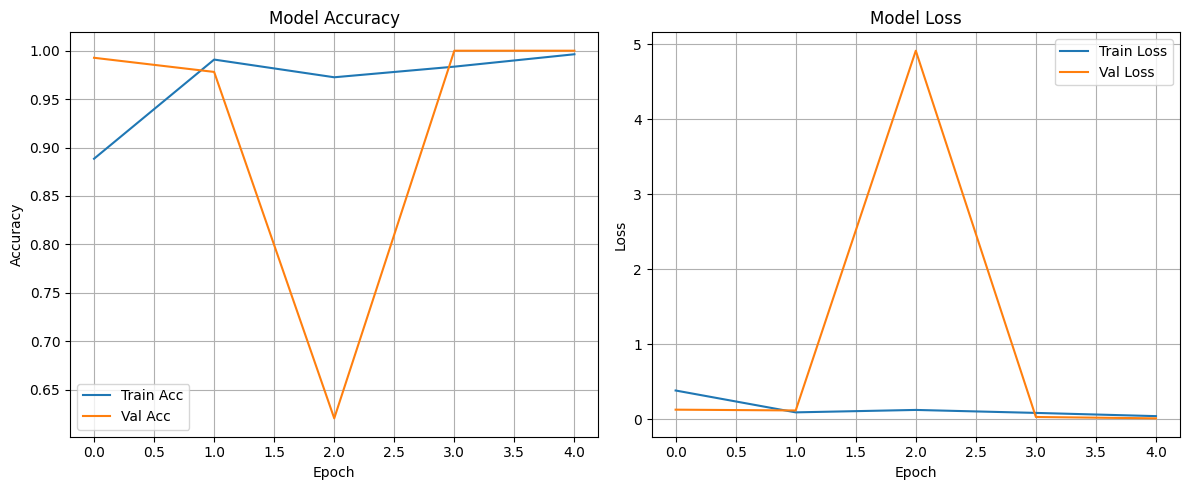

Evaluating model...


C:\Users\DELL\AppData\Local\Temp\ipykernel_23108\498699473.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_test[i:i+batch_size], dtype=torch.float32).permute(0, 2, 1, 3, 4).to(device)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23108\498699473.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_test[i:i+batch_size], dtype=torch.float32).to(device)
C:\Users\DELL\AppData\Local\Temp\ipykernel_23108\498699473.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_test_np = np.array(y_test).astype(int).ravel()


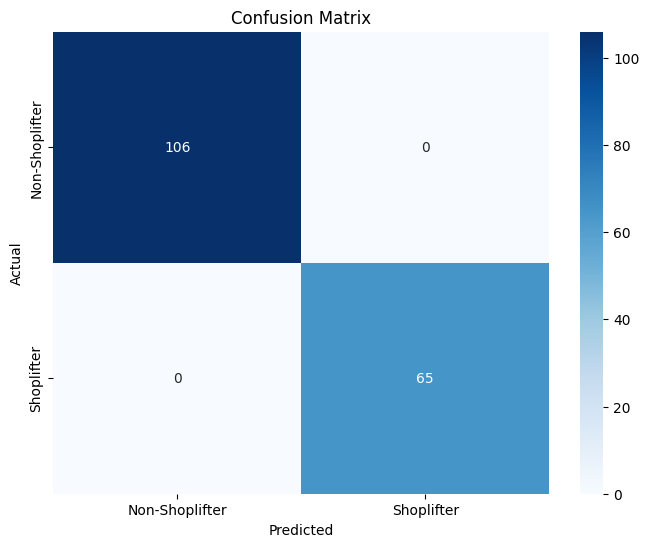

Classification Report:
                precision    recall  f1-score   support

Non-Shoplifter       1.00      1.00      1.00       106
    Shoplifter       1.00      1.00      1.00        65

      accuracy                           1.00       171
     macro avg       1.00      1.00      1.00       171
  weighted avg       1.00      1.00      1.00       171



In [14]:
plot_training_history(history)
print("Evaluating model...")
y_pred, y_pred_probs = evaluate_model(model, X_test, y_test, device)


In [15]:
torch.save(model.state_dict(), "shoplifting_model6.pth")